In [1]:
import cv2
import numpy as np
import os

from tqdm import tqdm

IMG_SIZE = 128
DATA_DIR = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer"

CATEGORIES = ['brain_tumor', 'brain_glioma', 'brain_menin']

data = []

for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATA_DIR, category)
    for img_name in tqdm(os.listdir(folder_path), desc=f"Loading {category}"):
        try:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append((img, label))
        except Exception as e:
            print(f"Hata: {e}, Dosya: {img_path}")

# Karıştır ve ayır
import random
random.shuffle(data)

X = np.array([i[0] for i in data]) / 255.0  # normalize
y = np.array([i[1] for i in data])

Loading brain_menin: 100%|██████████| 2004/2004 [00:23<00:00, 84.16it/s]


In [2]:
X.shape
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([2048, 2004, 2004]))

In [3]:
from sklearn.model_selection import train_test_split

# %70 eğitim, %15 doğrulama, %15 test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 4239, Val: 908, Test: 909


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

2025-07-12 15:29:22.399972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752334162.582870      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752334162.635960      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752334175.158218      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,843,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,862,723 (7.11 MB)

 Trainable params: 1,862,723 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100,
    #callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1752334178.736897      97 service.cc:148] XLA service 0x78d99400b560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752334178.737653      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752334178.982228      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/133 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.3681 - loss: 1.4234

I0000 00:00:1752334181.124741      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.5599 - loss: 0.9189 - val_accuracy: 0.7104 - val_loss: 0.6608
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.7014 - loss: 0.6655 - val_accuracy: 0.7797 - val_loss: 0.5391
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.7439 - loss: 0.5978 - val_accuracy: 0.7974 - val_loss: 0.5036
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.7621 - loss: 0.5562 - val_accuracy: 0.8128 - val_loss: 0.4846
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.7579 - loss: 0.5963 - val_accuracy: 0.8271 - val_loss: 0.4379
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.7992 - loss: 0.4945 - val_accuracy: 0.8326 - val_loss: 0.4254
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.7888 - loss: 0.5013 - val_accuracy: 0.8139 - val_loss: 0.4677
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.8078 - loss: 0.477

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Doğruluk: {test_acc:.4f}")

Test Doğruluk: 0.9527


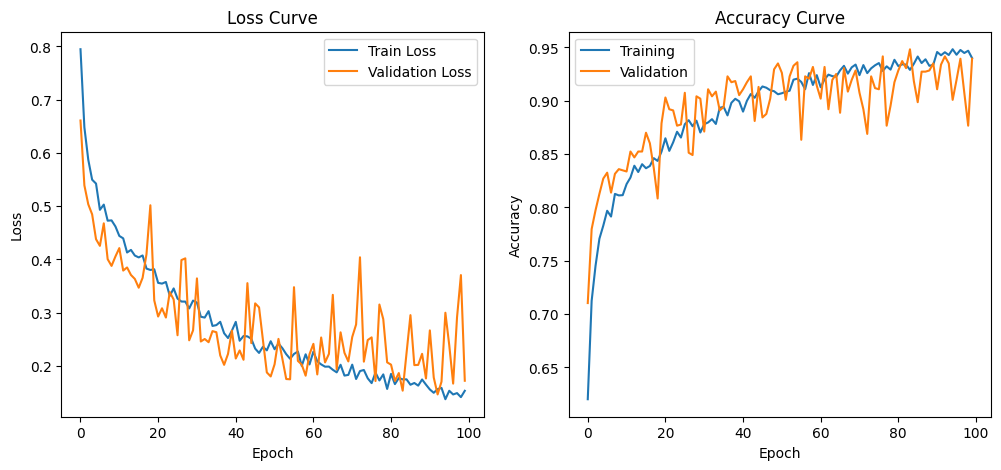

In [8]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybı
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('1.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = y_test

print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

print("\nMacro F1 Score:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1 Score:", f1_score(y_true, y_pred, average='weighted'))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report:

              precision    recall  f1-score   support

           0     0.9346    0.9740    0.9539       308
           1     0.9764    0.9635    0.9699       301
           2     0.9485    0.9200    0.9340       300

    accuracy                         0.9527       909
   macro avg     0.9532    0.9525    0.9526       909
weighted avg     0.9530    0.9527    0.9526       909

Confusion Matrix:

[[300   1   7]
 [  3 290   8]
 [ 18   6 276]]

Macro F1 Score: 0.9526016297927447
Weighted F1 Score: 0.9526320429607911


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       308
           1       0.98      0.96      0.97       301
           2       0.95      0.92      0.93       300

    accuracy                           0.95       909
   macro avg       0.95      0.95      0.95       909
weighted avg       0.95      0.95      0.95       909



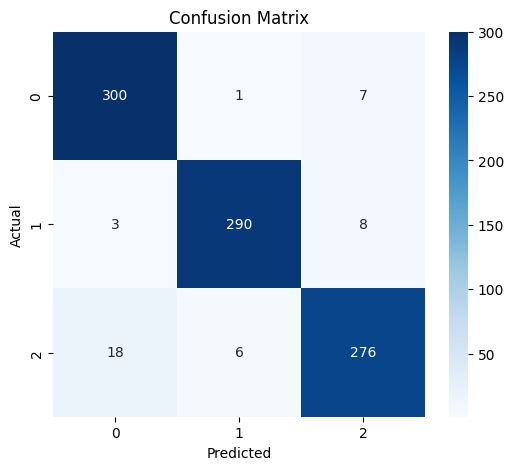

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Classification Report
print("🧾 Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 4. Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('CM_CNN.png', dpi=300, bbox_inches='tight')
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


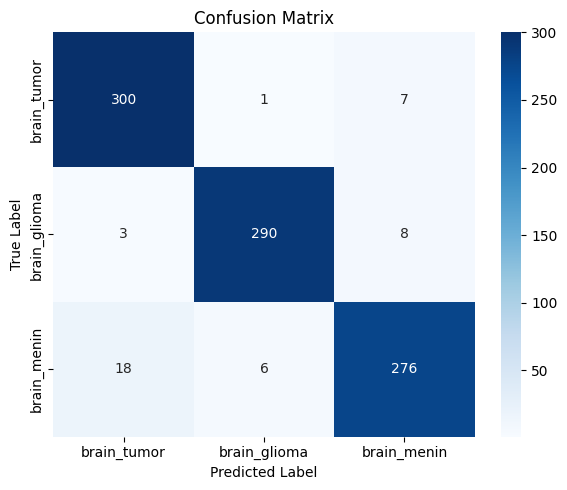

Classification Report:
              precision    recall  f1-score   support

 brain_tumor       0.93      0.97      0.95       308
brain_glioma       0.98      0.96      0.97       301
 brain_menin       0.95      0.92      0.93       300

    accuracy                           0.95       909
   macro avg       0.95      0.95      0.95       909
weighted avg       0.95      0.95      0.95       909



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Define class names
class_names = ['brain_tumor', 'brain_glioma', 'brain_menin']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('CM_CNN.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


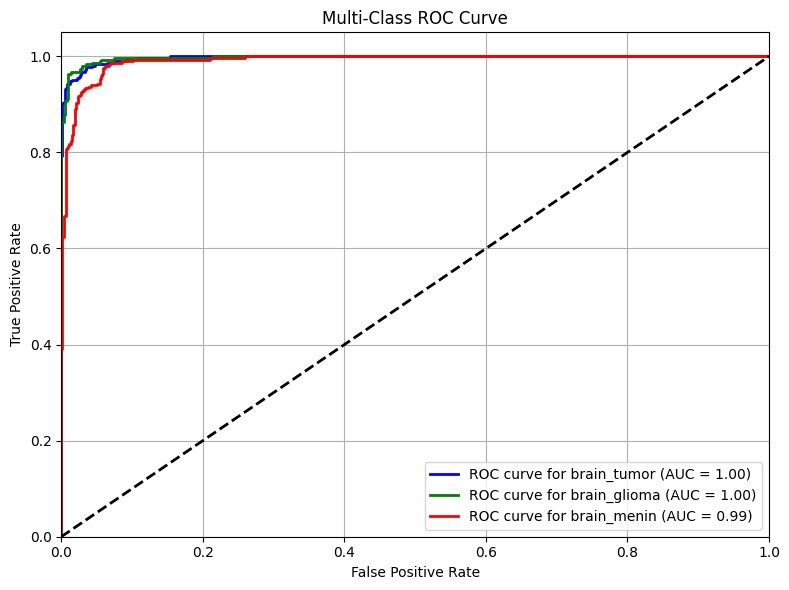

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Class names
class_names = ['brain_tumor', 'brain_glioma', 'brain_menin']
n_classes = len(class_names)

# 1. Get predicted probabilities
y_pred_probs = model.predict(X_test)

# 2. Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# 3. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_CNN.png', dpi=300, bbox_inches='tight')
plt.show()
